In [18]:
import numpy as np
from astropy.io import ascii


# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)

# Read Gxs
filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)



###### Chequeando que las dos muestras tengan el mismo rango de posiciones

print('Gxs DEC range:%5.2fdeg - %5.2fdeg' % (data['_DEJ2000'].min(),data['_DEJ2000'].max()))
print('Gxs RA range:%5.2fdeg - %5.2fdeg' % (data['_RAJ2000'].min(),data['_RAJ2000'].max()))

print('UHECR DEC range:%5.2fdeg - %5.2fdeg' % (events_a8['dec'].min(),events_a8['dec'].max()))
print('UHECR RA range:%5.2fdeg - %5.2fdeg' % (events_a8['RA'].min(),events_a8['RA'].max()))


Gxs DEC range:-87.77deg - 44.95deg
Gxs RA range: 0.81deg - 359.86deg
UHECR DEC range:-89.90deg - 44.70deg
UHECR RA range: 0.00deg - 360.00deg


In [19]:
import treecorr
import numpy as np

gcat = treecorr.Catalog(filename_g, ra_col='_RAJ2000', dec_col='_DEJ2000', ra_units='deg', dec_units='deg')
ecat = treecorr.Catalog(filename_e, ra_col='RA', dec_col='dec', ra_units='deg', dec_units='deg')

print('ra range = %f .. %f' % (gcat.ra.min(), gcat.ra.max()))
print('dec range = %f .. %f' % (gcat.dec.min(), gcat.dec.max()))

ra range = 0.014177 .. 6.280677
dec range = -1.531915 .. 0.784610


In [20]:

ra_min = np.min(gcat.ra)
ra_max = np.max(gcat.ra)
dec_min = np.min(gcat.dec)
dec_max = np.max(gcat.dec)
print('ra range = %f .. %f' % (ra_min, ra_max))
print('dec range = %f .. %f' % (dec_min, dec_max))

rand_ra = np.random.uniform(ra_min, ra_max, gcat.ntot*50)
rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), gcat.ntot*50)
rand_dec = np.arcsin(rand_sindec)
print('ra range = %f .. %f' % (rand_ra.min(), rand_ra.max()))
print('dec range = %f .. %f' % (rand_dec.min(), rand_dec.max()))

ra range = 0.014177 .. 6.280677
dec range = -1.531915 .. 0.784610
ra range = 0.014211 .. 6.280471
dec range = -1.531549 .. 0.784602


#### Plottear todo, just in case

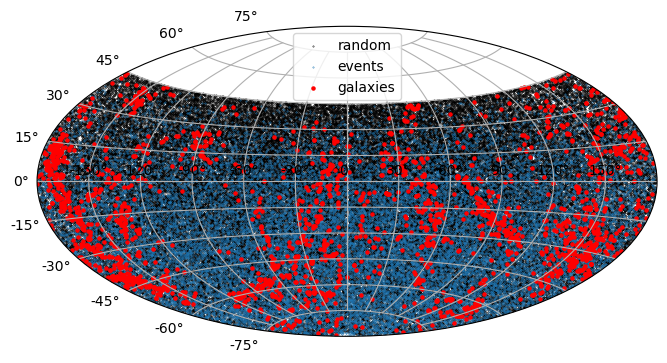

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

gxs = SkyCoord(data['_RAJ2000'],data['_DEJ2000'],frame='icrs',unit='degree')
eve = SkyCoord(events_a8['RA'],events_a8['dec'],frame='icrs',unit='degree')
ran = SkyCoord(rand_ra,rand_dec,frame='icrs',unit='rad')

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(ran.ra.wrap_at(180*u.degree).to(u.rad),ran.dec.to(u.rad),s=.1,c='k',label='random')
ax.scatter(eve.ra.wrap_at(180*u.degree).to(u.rad),eve.dec.to(u.rad),s=.1,label='events')
ax.scatter(gxs.ra.wrap_at(180*u.degree).to(u.rad),gxs.dec.to(u.rad),s=5,c='r',label='galaxies')
ax.legend()
ax.grid(True)
plt.show()

#### Probar calcular la autocorrelacion

In [22]:
#data = treecorr.Catalog(data_file, config)
#rand = treecorr.Catalog(rand_file, config)

minsep = 10.
maxsep = 90.
nbins = 15

dd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')
dr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')

rcat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians')
rr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')

rr.process(rcat)
dd.process(gcat)
dr.process(gcat,rcat)

xi, varxi = dd.calculateXi(rr=rr,dr=dr)

[ 0.82568462  0.74516273  0.61958774  0.43309803  0.32966745  0.30574337
  0.29387402  0.34040381  0.31233236  0.2598746   0.18835376  0.07051364
 -0.04983003 -0.08238551 -0.09194002]


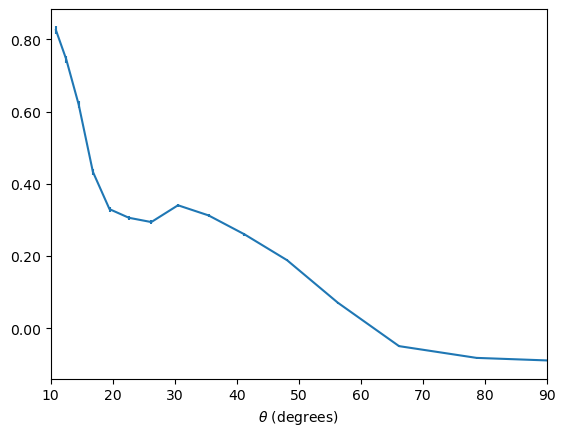

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mtick

fig, ax = plt.subplots()

sig = np.sqrt(varxi)
print(xi)
r = np.exp(dd.meanlogr)

np.savez('../data/treecorr.npz',r,xi,sig)

#ax.plot(r, xi, color='blue')
ax.errorbar(r,xi,yerr=sig)
#ax.plot(r, -xi, color='blue', ls=':')
#ax.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=1)
#ax.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=1)
#leg = ax.errorbar(-r, xi, yerr=sig, color='blue')

#ax.set_xscale('log')
#ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\theta$ (degrees)')

#ax.legend([leg], [r'$w(\theta)$'], loc='lower left')
ax.set_xlim([10,90])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
#ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

#plt.axis

plt.show()

#### Probar la Cross-Corr

In [8]:
minsep = 10.
maxsep = 90.
nbins = 15

rcat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians')


dd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')
dr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')
rr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')
rd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')

rr.process(rcat)
dd.process(gcat,ecat)
dr.process(gcat,rcat)
rd.process(rcat,gcat)

xi, varxi = dd.calculateXi(rr=rr,dr=dr,rd=rd)

[0.0087713  0.00762272 0.00660736 0.00571835 0.00495661 0.00429625
 0.00372333 0.00323414 0.00280968 0.00244176 0.00212635 0.00185809
 0.0016198  0.0014157  0.00123172]


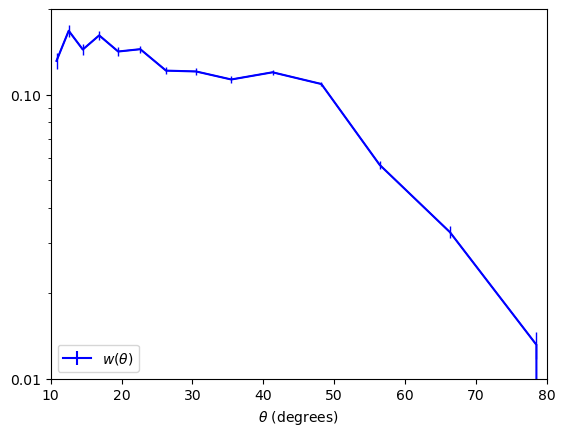

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

sig = np.sqrt(varxi)
print(sig)
r = np.exp(dd.meanlogr)

ax.plot(r, xi, color='blue')
ax.plot(r, -xi, color='blue', ls=':')
ax.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=1)
ax.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=1)
leg = ax.errorbar(-r, xi, yerr=sig, color='blue')

#ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\theta$ (degrees)')

ax.legend([leg], [r'$w(\theta)$'], loc='lower left')
ax.set_xlim([10,80])
ax.set_ylim([.01,.2])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
#ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

#plt.axis

plt.show()

#### Probar Cross con Bright/Faint

In [1]:
from astropy.io import ascii
import numpy as np

# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
#events_a8 = ascii.read(filename_e)

# Read Gxs
filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

# Bright/Faint
data_bright = data[(data['K_abs']<-23.2)&(data['K_abs']>-26.)]
data_faint = data[(data['K_abs']>-23.2)&(data['K_abs']<-22.)]

# Random Catalogue
nmult = 50 #N_r/N_d (int)
ra1_min = np.min(data_bright['_RAJ2000'].min())
ra1_max = np.max(data_bright['_RAJ2000'].max())
dec1_min = np.min(data_bright['_DEJ2000'].min())
dec1_max = np.max(data_bright['_DEJ2000'].max())
ra2_min = np.min(data_faint['_RAJ2000'].min())
ra2_max = np.max(data_faint['_RAJ2000'].max())
dec2_min = np.min(data_faint['_DEJ2000'].min())
dec2_max = np.max(data_faint['_DEJ2000'].max())

rand_ra1 = np.random.uniform(ra1_min, ra1_max, len(data_bright)*nmult)
rand_sindec1 = np.random.uniform(np.sin(dec1_min*np.pi/180.), np.sin(dec1_max*np.pi/180.), \
                                 len(data_bright)*nmult)
rand_dec1 = np.arcsin(rand_sindec1)*180./np.pi

rand_ra2 = np.random.uniform(ra2_min, ra2_max, len(data_bright)*nmult)
rand_sindec2 = np.random.uniform(np.sin(dec2_min*np.pi/180.), np.sin(dec2_max*np.pi/180.), \
                                 len(data_bright)*nmult)
rand_dec2 = np.arcsin(rand_sindec2)*180./np.pi


In [14]:
"""
BRIGHT
"""
# TreeCorr Catalogues
import treecorr

gcat = treecorr.Catalog(ra=data_bright['_RAJ2000'], dec=data_bright['_DEJ2000'],ra_units='deg', dec_units='deg')
ecat = treecorr.Catalog(filename_e, ra_col='RA', dec_col='dec', ra_units='deg', dec_units='deg')
rcat1 = treecorr.Catalog(ra=rand_ra1, dec=rand_dec1, ra_units='deg', dec_units='deg')
rcat2 = treecorr.Catalog(ra=rand_ra2, dec=rand_dec2, ra_units='deg', dec_units='deg')

minsep = 10.
maxsep = 150.
nbins = 15

dd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree', \
                            bin_type='Linear', brute=True, metric='Arc')
dr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree',\
                             bin_type='Linear', brute=True, metric='Arc')
rr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree', \
                            bin_type='Linear', brute=True, metric='Arc')
rd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree', \
                            bin_type='Linear', brute=True, metric='Arc')

rr.process(rcat1)
dd.process(gcat,ecat)
dr.process(gcat,rcat1)
rd.process(ecat,rcat1)

xi1, varxi1 = dd.calculateXi(rr=rr,dr=dr,rd=rd)

In [18]:
"""
FAINT
"""


gcat = treecorr.Catalog(ra=data_faint['_RAJ2000'], dec=data_faint['_DEJ2000'],\
                        ra_units='deg', dec_units='deg')
ecat = treecorr.Catalog(filename_e, ra_col='RA', dec_col='dec', ra_units='deg', dec_units='deg')
rcat1 = treecorr.Catalog(ra=rand_ra1, dec=rand_dec1, ra_units='deg', dec_units='deg')
rcat2 = treecorr.Catalog(ra=rand_ra2, dec=rand_dec2, ra_units='deg', dec_units='deg')

minsep = 10.
maxsep = 150.
nbins = 15

dd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree',\
                             bin_type='Linear', brute=True, metric='Arc')
dr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree', \
                            bin_type='Linear', brute=True, metric='Arc')
rr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree', \
                            bin_type='Linear', brute=True, metric='Arc')
rd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree', \
                            bin_type='Linear', brute=True, metric='Arc')

rr.process(rcat2)
dd.process(gcat,ecat)
dr.process(gcat,rcat2)
rd.process(ecat,rcat2)

xi2, varxi2 = dd.calculateXi(rr=rr,dr=dr,rd=rd)

[0.00170953 0.00138553 0.00119791 0.00109517 0.00102092 0.00098127
 0.00095444 0.00094149 0.00093945 0.00094271 0.00096112 0.00099757
 0.00104912 0.0011205  0.00124004] [0.00172702 0.00139576 0.00120178 0.0011018  0.00102893 0.00098953
 0.00095923 0.0009491  0.00094783 0.00095228 0.00097153 0.00100759
 0.00105651 0.00113752 0.00126044]


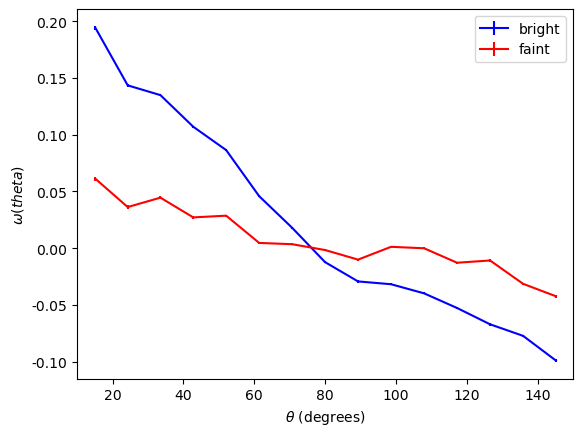

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

sig1 = np.sqrt(varxi1)
sig2 = np.sqrt(varxi2)
print(sig1,sig2)
r = np.exp(dd.meanlogr)
r = dd.meanr

ax.errorbar(r, xi1, yerr=sig1, color='blue', label='bright')
ax.errorbar(r, xi2, yerr=sig2, color='red', label='faint')

ax.legend()

ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$\omega(theta)$')

ax.set_xlim([10,150])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.savefig('../data/cross_treecorr_bf.png')
plt.show()


In [ ]:

np.savez('../data/treecorr_cross_bright.npz',r,xi1,sig1)
np.savez('../data/treecorr_cross_faint.npz',r,xi2,sig2)